In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy.sql import text
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [42]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [43]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [44]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [45]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [46]:
# Find the most recent date in the data set.
result = session.execute('SELECT date FROM Measurement ORDER BY date DESC LIMIT 1')
most_recent_date = result.scalar()
print(f"The most recent date in the data set is {most_recent_date}.")

The most recent date in the data set is 2017-08-23.


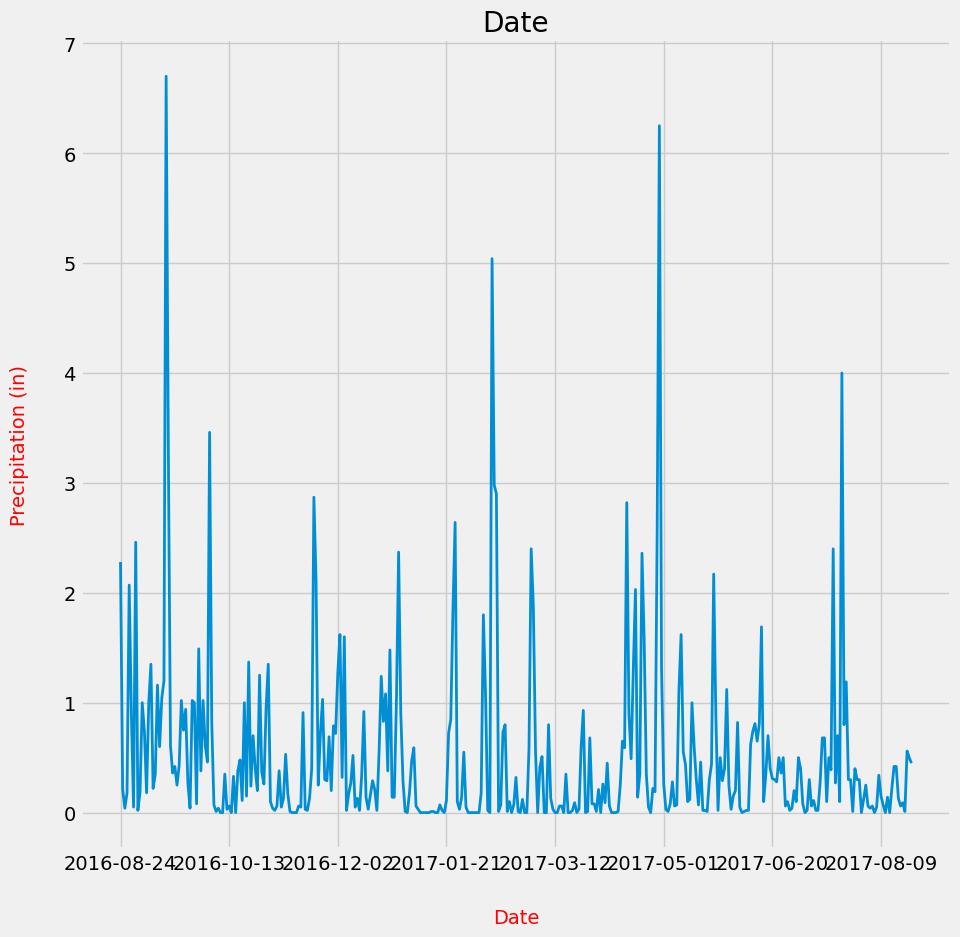

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (session.query(Measurement.date,func.max(Measurement.prcp)).filter(func.strftime('%Y-%m-%d',Measurement.date) > one_year_ago_date).group_by(Measurement.date).all())

precipitation_data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('date',inplace=True)
precipitation_df
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(10,10)
precipitation_df.plot(linewidth=2,rot=0)
plt.xlabel('Date',fontsize=14,color='Red',labelpad=25)
plt.ylabel('Precipitation (in)',fontsize=14,color='Red',labelpad=25)
plt.title('Date')
plt.legend('',frameon=False)



plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
print(f'There are {total_stations} stations')

There are 9 stations


In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stmt = text("SELECT station, COUNT(station) AS station_count " +
            "FROM measurement " +
            "GROUP BY station " +
            "ORDER BY station_count DESC")

most_active_stations = session.execute(stmt).fetchall()
for station, count in most_active_stations:
    print(f"Station {station} had {count} observations.")

Station USC00519281 had 2772 observations.
Station USC00519397 had 2724 observations.
Station USC00513117 had 2709 observations.
Station USC00519523 had 2669 observations.
Station USC00516128 had 2612 observations.
Station USC00514830 had 2202 observations.
Station USC00511918 had 1979 observations.
Station USC00517948 had 1372 observations.
Station USC00518838 had 511 observations.


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()[0]
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temp_stats = session.query(*sel).\
            filter(Measurement.station == most_active_station).all()
print(f"Temperature stats for station {most_active_station}:")
print(f"Lowest temperature: {temp_stats[0][0]} F")
print(f"Highest temperature: {temp_stats[0][1]} F")
print(f"Average temperature: {temp_stats[0][2]} F")

Temperature stats for station USC00519281:
Lowest temperature: 54.0 F
Highest temperature: 85.0 F
Average temperature: 71.66378066378067 F


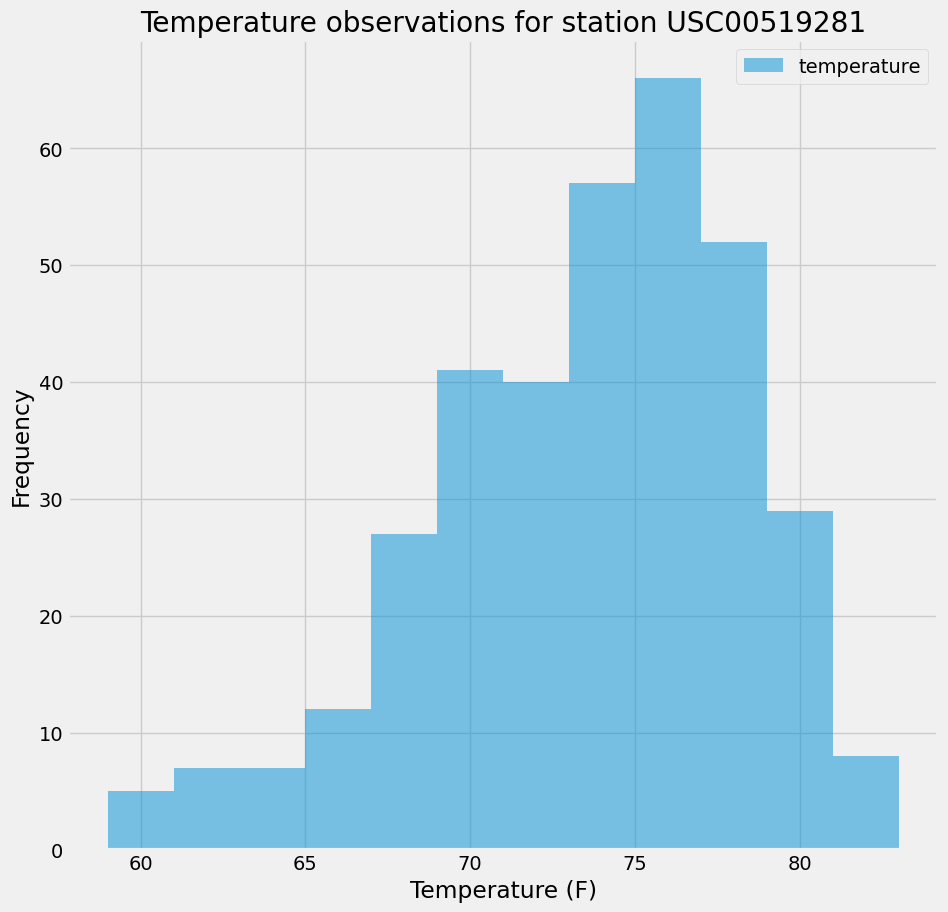

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()[0]

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = datetime.strptime(last_date, '%Y-%m-%d') - timedelta(days=365)

temps = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= one_year_ago).\
            order_by(Measurement.date).all()

temps_df = pd.DataFrame(temps, columns=['temperature'])
temps_df.plot.hist(bins=12, alpha=0.5)
plt.title(f"Temperature observations for station {most_active_station}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [53]:
# Close Session
session.close()